# Capstone Project - The Battle of Electronic Stores 

*** To see the maps please use jupyer nbviewer or click [here](https://nbviewer.jupyter.org/github/jjobel/IBM_DS_Capstone_Project/blob/master/Capstone_Project%20_The_Battle_of_the_Electronics_Stores.ipynb) ***

## Table of Contents 
* [Business Problem](#intro)
* [Data](#data)
* [Methodology](#meth)
* [Analysis](#analysis)
* [Results & Discussion](#res)
* [Conclusion](#con)

## Business Problem <a name="intro"></a>

This project is geared toward stakeholders particularly interested in identifying an optimal location for a **computer electronics store** business in Los Angeles, California. The business is aimed at computer enthusiast and professional online gamers, thus providing a large variety of computers, computer parts, electronics, softwares, and gaming supplies. 

We will focus our attention on locations which **do not have an electronics stores in the area and are not primarly residential neighborhoods**. We would also prefer to consider locations of high popularity which **contain malls, shopping centers, and/or a large population of retail stores in the area**. The latter having greater weight in our recommendation. 

Three location will then be recommended based on how close they satifies the above criteria along with a description of the advantages of choosing that location.  

## Data <a name="data"></a>

The data used consists of the following:

* Names of neighborhoods and regions within Los Angeles County were obtained through web scraping the Los Angeles Times' Mapping LA project using the Beautiful Soup library. This data has been previously used by the City of Los Angeles Open Data portal to map out neighborhood boundaries.

* We make use of the neighborhood names data to obtain the longitude and latitude coordinates of each neighborhood using the geopy library. 

* We use the Foursquare API to obtain the most common venues in each neighborhood.

#### Importing Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

import requests
from pandas.io.json import json_normalize

from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim, GoogleV3

#!pip -q install folium 
import folium

#### Neighborhoods

We'll create a Pandas Dataframe from the table data in the Los Angeles Times' Mapping LA project webpage using Beautiful Soup. 

In [2]:
# Lets create a link to the Los Angeles Times' Mapping LA project webpage.

url_la = "http://maps.latimes.com/neighborhoods/neighborhood/list/"

content = requests.get(url_la).text

# Using BeautifulSoup, we use Python's html.parser to parse through the html file.
soup = BeautifulSoup(content, 'html.parser')

Now we find the contents of the webpage using the BeautifulSoup 'find()' method which scans the html doc for the given label and attribute. To identify the two input arguments we need to use Google Chrome's Developer Tools. 

In our case, both arguments are name='table' and attrs={'class': 'datagrid'}.

In [3]:
la_table = soup.find('table', attrs={'class':'datagrid'})

df_la = pd.read_html(str(la_table))

# Lets create the dataframe. 
df_la = pd.DataFrame(df_la[0])

# We'll rename one of column names. 
df_la.rename(columns={"Name":"Neighborhood"}, inplace=True)

print(f"The number of neighborhoods in the Los Angeles County, CA are {len(df_la['Neighborhood'].unique())}.")
df_la.head(20)

The number of neighborhoods in the Los Angeles County, CA are 272.


Neighborhood                  Region
0                    Acton         Antelope Valley
1          Adams-Normandie              South L.A.
2             Agoura Hills  Santa Monica Mountains
3               Agua Dulce        Northwest County
4                 Alhambra      San Gabriel Valley
5             Alondra Park               South Bay
6                 Altadena                Verdugos
7            Angeles Crest          Angeles Forest
8                  Arcadia      San Gabriel Valley
9                   Arleta     San Fernando Valley
10       Arlington Heights            Central L.A.
11                 Artesia               Southeast
12                  Athens              South L.A.
13         Atwater Village          Northeast L.A.
14                  Avalon                  Harbor
15         Avocado Heights      San Gabriel Valley
16                   Azusa      San Gabriel Valley
17  Baldwin Hills/Crenshaw              South L.A.
18            Baldwin Park      San Gabriel Valley
19                 Bel-Air                Westside

Note that the Los Angeles Time's Mapping LA project includes the entire **Los Angeles County** which contains mountain regions, naional parks, and nearby cities. Our focus is on the **City of Los Angeles** thus we will use the City of Los Angeles open portal data to constrain our dataframe to only neighborhoods that fall inside the city of LA.

In [4]:
# The City of Los Angeles open portal provides a csv file with 114 neighborhoods wihin the city.  
body = "LA_Times_Neighborhood_Boundaries.csv"
df_data_1 = pd.read_csv(body)

print(f"The City of Los Angeles open portal data contains {len(df_data_1['name'].unique())} neighborhoods")
df_data_1.head()

The City of Los Angeles open portal data contains 114 neighborhoods


OBJECTID                    name
0         1         Adams-Normandie
1         2                  Arleta
2         3       Arlington Heights
3         4         Atwater Village
4         5  Baldwin Hills/Crenshaw

Now that we have the neighborhoods solely in the city of Los Angeles let us remove all other nearby neighborhoods from 'df_la'.  

In [5]:
# We'll only keep neighborhoods in city of LA.
df_la = df_la[df_la["Neighborhood"].isin(df_data_1['name'])]

print(f"The total number of neighborhoods in the city of Los Angeles are {len(df_la['Neighborhood'].unique())}")

df_la.head(20)

The total number of neighborhoods in the city of Los Angeles are 114


Neighborhood               Region
1          Adams-Normandie           South L.A.
9                   Arleta  San Fernando Valley
10       Arlington Heights         Central L.A.
13         Atwater Village       Northeast L.A.
17  Baldwin Hills/Crenshaw           South L.A.
19                 Bel-Air             Westside
23           Beverly Crest             Westside
24           Beverly Grove         Central L.A.
26             Beverlywood             Westside
27           Boyle Heights             Eastside
29               Brentwood             Westside
30     Broadway-Manchester           South L.A.
33             Canoga Park  San Fernando Valley
35                 Carthay         Central L.A.
38         Central-Alameda           South L.A.
39            Century City             Westside
42              Chatsworth  San Fernando Valley
43    Chatsworth Reservoir  San Fernando Valley
44     Chesterfield Square           South L.A.
45           Cheviot Hills             Westside

#### Obtaining Latitudes and Longitudes

In [6]:
lng = []
lat = []
for name in df_la['Neighborhood']:
    
    try:
        address = f'{name}, CA'

        geolocator = Nominatim(user_agent="my-project")
        location = geolocator.geocode(address)
        lat.append(location.latitude)
        lng.append(location.longitude)
        
    except:
        print(f"Could not find latitude/longitude coordinates for {name}, CA")

# Create latitude/longitude columns
df_la["Latitude"] = lat
df_la["Longitude"] = lng

# Now we have geo coordinates for each neighborhood
# We'll sort the dataframe based on regions
df_la.sort_values("Region", inplace=True)
df_la.reset_index(inplace=True, drop=True)

df_la.head(30)

Neighborhood        Region   Latitude   Longitude
0           Hancock Park  Central L.A.  34.067780 -118.332635
1   Hollywood Hills West  Central L.A.  34.110485 -118.373388
2        Hollywood Hills  Central L.A.  34.131179 -118.335547
3              Hollywood  Central L.A.  34.098003 -118.329523
4              Larchmont  Central L.A.  34.079837 -118.317870
5        Harvard Heights  Central L.A.  34.047111 -118.305483
6          Griffith Park  Central L.A.  34.135814 -118.294789
7              Los Feliz  Central L.A.  34.108214 -118.290032
8               Mid-City  Central L.A.  34.041527 -118.360370
9           Mid-Wilshire  Central L.A.  34.056862 -118.345803
10               Fairfax  Central L.A.  37.987293 -122.587967
11        Elysian Valley  Central L.A.  34.095913 -118.242033
12          Elysian Park  Central L.A.  34.077434 -118.238620
13        East Hollywood  Central L.A.  34.090428 -118.296625
14              Downtown  Central L.A.  34.042849 -118.247673
15             Chinatown  Central L.A.  34.063840 -118.235868
16             Echo Park  Central L.A.  34.074000 -118.260874
17             Koreatown  Central L.A.  34.061794 -118.305447
18           Silver Lake  Central L.A.  34.089652 -118.269374
19         Beverly Grove  Central L.A.  34.076034 -118.369972
20              Westlake  Central L.A.  34.062923 -118.272820
21            Pico-Union  Central L.A.  34.046567 -118.287894
22               Carthay  Central L.A.  34.061121 -118.367300
23        Windsor Square  Central L.A.  34.072593 -118.320810
24     Arlington Heights  Central L.A.  34.043494 -118.321374
25       Lincoln Heights      Eastside  34.070929 -118.209890
26             El Sereno      Eastside  34.081121 -118.177849
27         Boyle Heights      Eastside  34.043689 -118.209768
28        Harbor Gateway        Harbor  33.854225 -118.299220
29           Harbor City        Harbor  33.791101 -118.301260

#### Fouresquare

Great! We now have a complete list of all the neighborhoods that reside in the city of Los Angeles.

Our next step will be to use the Foursquare API to obtain information about what type of businesses there are in a given neighborhood. The information we get back will also tell us whether a nieghborhood is primarily residential. 

In [7]:
# @hidden_cell

CLIENT_ID = 'MESNULNZT22XLOAYU44DXCSOWX5FHJ4ZCQDUPMXGUXVSPGDY'
CLIENT_SECRET = 'A4LZKCMPPKFV34MIAVYBTX3ESF34554BKHRF0FA1MEWNTGIP'
VERSION = '20200604'
LIMIT = 100
RADIUS = 500

Lets explore the businesses around all the neighborhoods. 

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):    
    """Obtains the venues within a 500m radius around a given location."""
    
    category_id = '4d4b7105d754a06378d81259'  #Shop&Service venue category
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # API URL
        url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            category_id,
            radius,
            LIMIT)
        
        # GET request 
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # Append the relevant info from results
        venues_list.append([(
            name,
            lat,
            lng,
            ven['venue']['name'],
            ven['venue']['location']['lat'],
            ven['venue']['location']['lng'],
            ven['venue']['categories'][0]['name']) for ven in results])
        
        # Let's build the dataframe from venues_list
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        
        nearby_venues.columns = ['Neighborhood', 
                                 'Neighborhood Latitude',
                                 'Neighborhood Longitude',
                                 'Venue',
                                 'Venue Latitude',
                                 'Venue Longitude',
                                 'Venue Category']
    return(nearby_venues)

Let's call the getNearbyVenues() function we created above and print out some basic information about our new dataframe.

In [9]:
la_venues = getNearbyVenues(df_la['Neighborhood'], df_la['Latitude'], df_la['Longitude'])

print(f"There are {la_venues.shape[0]} venues within the Shop & Service venue category that Foursquare recognizes.")
print(f"The number of neighborhoods Foursquare returns that contain venues is {len(la_venues['Neighborhood'].unique())} out of {len(df_la['Neighborhood'])} neighborhoods we were considering.")

la_venues.head(15)

There are 3535 venues within the Shop & Service venue category that Foursquare recognizes.
The number of neighborhoods Foursquare returns that contain venues is 105 out of 114 neighborhoods we were considering.


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0           Hancock Park              34.067780             -118.332635   
1           Hancock Park              34.067780             -118.332635   
2           Hancock Park              34.067780             -118.332635   
3   Hollywood Hills West              34.110485             -118.373388   
4   Hollywood Hills West              34.110485             -118.373388   
5   Hollywood Hills West              34.110485             -118.373388   
6        Hollywood Hills              34.131179             -118.335547   
7        Hollywood Hills              34.131179             -118.335547   
8              Hollywood              34.098003             -118.329523   
9              Hollywood              34.098003             -118.329523   
10             Hollywood              34.098003             -118.329523   
11             Hollywood              34.098003             -118.329523   
12             Hollywood              34.098003             -118.329523   
13             Hollywood              34.098003             -118.329523   
14             Hollywood              34.098003             -118.329523   

                                     Venue  Venue Latitude  Venue Longitude  \
0                        Chloe Massage Spa       34.067983      -118.332410   
1        Los Angeles Mobile App Developers       34.068979      -118.328118   
2                        Leading Tax Group       34.065761      -118.327884   
3              Laurel Canyon Country Store       34.108925      -118.369616   
4               Jeff Pinette | Photography       34.108522      -118.377870   
5                           Built By Blank       34.108528      -118.377884   
6   State Wide Construction and Remodeling       34.130489      -118.340357   
7                                 wineVEIL       34.131387      -118.340860   
8                Hollywood Farmer's Market       34.099769      -118.328653   
9                          Space 15 Twenty       34.098847      -118.329160   
10                      K&L Wine Merchants       34.096524      -118.326393   
11                                MMD, Inc       34.098505      -118.329587   
12                      The Record Parlour       34.099746      -118.329918   
13                            Trader Joe's       34.100117      -118.326671   
14                       Bed Bath & Beyond       34.099342      -118.327044   

                Venue Category  
0               Massage Studio  
1             Business Service  
2                       Lawyer  
3                Grocery Store  
4           Photography Studio  
5                  IT Services  
6   Construction & Landscaping  
7                    Wine Shop  
8               Farmers Market  
9                Shopping Mall  
10                   Wine Shop  
11        Marijuana Dispensary  
12                 Record Shop  
13               Grocery Store  
14      Furniture / Home Store

Notice that we now have less neighborhoods than what was passed through the getNearbyVenues() method. This is because the Foursquare API returns neighborhoods which have venues within a 500m radius and in return removes locations which have no businesses in the surrounding area. This is great because now we only have locations that contain businesses. 

Generally, electronics stores do not offer in-store computer parts or hardware in their stores but do offer them on their websites for customers to pickup in-store or have the parts delivered to them. We will take a conservative approach toward our analysis and assume that all electronics stores pose a competition to the stackholder's business. This in return allows us to remove neighborhoods that host electronics stores from our data and focus on recommending locations which do not have them.

Let's go ahead and isolate the electronics store onto a seperate dataframe called `elec_neigh`.

In [10]:
elec_neigh = la_venues[la_venues['Venue Category'] == 'Electronics Store']

print(f"The number of electronics stores is {elec_neigh.shape[0]} within {len(elec_neigh['Neighborhood'].unique())} neighborhoods")
elec_neigh.head(15)

The number of electronics stores is 59 within 33 neighborhoods


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
52         Hollywood              34.098003             -118.329523   
61         Hollywood              34.098003             -118.329523   
67         Hollywood              34.098003             -118.329523   
91         Hollywood              34.098003             -118.329523   
124  Harvard Heights              34.047111             -118.305483   
281          Fairfax              37.987293             -122.587967   
300   East Hollywood              34.090428             -118.296625   
343         Downtown              34.042849             -118.247673   
349         Downtown              34.042849             -118.247673   
378         Downtown              34.042849             -118.247673   
530        Echo Park              34.074000             -118.260874   
550        Echo Park              34.074000             -118.260874   
614        Koreatown              34.061794             -118.305447   
704    Beverly Grove              34.076034             -118.369972   
707    Beverly Grove              34.076034             -118.369972   

                                       Venue  Venue Latitude  Venue Longitude  \
52                              Input Output       34.098247      -118.328875   
61                             Ultimate Ears       34.098309      -118.330139   
67                         Times electrician       34.098248      -118.326958   
91                      Emergency Lights Co.       34.098526      -118.332970   
124                     Han's Appliance & TV       34.048672      -118.308586   
281                   Acoustic Frontiers LLC       37.987803      -122.584658   
300                              Loco 4 Tech       34.090909      -118.296061   
343  Spring Street Mac - iPhone & Mac Repair       34.045655      -118.251014   
349                                   iStore       34.043041      -118.250420   
378                  A-Appliance Xperts Inc.       34.043770      -118.251171   
530           Chris Castro Mac and PC Repair       34.072537      -118.263425   
550                             Rewind Audio       34.076937      -118.264068   
614                         Notebookshop.com       34.061367      -118.306305   
704      west hollywood iphone screen repair       34.076181      -118.370883   
707                           Sound Decision       34.076080      -118.369160   

        Venue Category  
52   Electronics Store  
61   Electronics Store  
67   Electronics Store  
91   Electronics Store  
124  Electronics Store  
281  Electronics Store  
300  Electronics Store  
343  Electronics Store  
349  Electronics Store  
378  Electronics Store  
530  Electronics Store  
550  Electronics Store  
614  Electronics Store  
704  Electronics Store  
707  Electronics Store

This is great! We now have the electronics stores in each neighborhood. 

Now that we have a good idea of where such businesses are established, lets create the dataframe that will consist of neighborhoods with no electronics stores called, `la_clean`.

In [11]:
la_clean = la_venues[~la_venues['Neighborhood'].isin(elec_neigh['Neighborhood'])]

print(f"The number of neighborhoods without electronics stores are {len(la_clean['Neighborhood'].unique())} out of {len(la_venues['Neighborhood'].unique())}.")
print(f"The total number of businesses in these neighborhoods are {la_clean.shape[0]}.")
la_clean.head(10)

The number of neighborhoods without electronics stores are 72 out of 105.
The total number of businesses in these neighborhoods are 1477.


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0            Hancock Park              34.067780             -118.332635   
1            Hancock Park              34.067780             -118.332635   
2            Hancock Park              34.067780             -118.332635   
3    Hollywood Hills West              34.110485             -118.373388   
4    Hollywood Hills West              34.110485             -118.373388   
5    Hollywood Hills West              34.110485             -118.373388   
6         Hollywood Hills              34.131179             -118.335547   
7         Hollywood Hills              34.131179             -118.335547   
108             Larchmont              34.079837             -118.317870   
109             Larchmont              34.079837             -118.317870   

                                      Venue  Venue Latitude  Venue Longitude  \
0                         Chloe Massage Spa       34.067983      -118.332410   
1         Los Angeles Mobile App Developers       34.068979      -118.328118   
2                         Leading Tax Group       34.065761      -118.327884   
3               Laurel Canyon Country Store       34.108925      -118.369616   
4                Jeff Pinette | Photography       34.108522      -118.377870   
5                            Built By Blank       34.108528      -118.377884   
6    State Wide Construction and Remodeling       34.130489      -118.340357   
7                                  wineVEIL       34.131387      -118.340860   
108               Design Build Maintain DBM       34.079659      -118.319839   
109            Social Security Law Attorney       34.083375      -118.315630   

                 Venue Category  
0                Massage Studio  
1              Business Service  
2                        Lawyer  
3                 Grocery Store  
4            Photography Studio  
5                   IT Services  
6    Construction & Landscaping  
7                     Wine Shop  
108  Construction & Landscaping  
109                      Lawyer

This looks good! We've successfully obtained the locations of venues inside neighborhoods which are not residential and do not have electronics store. This satisfies the criterias we initially identified in our business problem. 

Before we move on lets review the data we have collected so far.

* `df_la` contains the names of all 114 neighborhoods in the city of Los Angeles along with their associated regions. The dataframe is organized by regions, meaning all neighborhoods belonging to a certain region are grouped together. This dataframe also contains the geographical coordinates of each neighborhood.


* `la_venues` provides us information about the businesses within a neighborhood. We have business names, geographical coordinates, and the category a given business falls in. 


* `elec_neigh` provides similar information as `la_venues` with the exception that businesses represented in this dataframe are strictly electronics stores.


* `la_clean` also derived from the `la_venue` dataframe. `la_clean` provides information on all other businesses that are not electronics stores. The information in this dataframe will be used to make our recommendation later in the analysis. 

This concludes the data collection phase, we will now move forward on our analysis using the data we have collected thus far. 

## Methodology <a name="meth"></a>

The focus of this project is to recommend neighborhoods that host a high density of retail business that can fall into the Foursquare Shop $\&$ Service category and do not have electronics stores in them. We limit our search to a 500m radius around each neighborhood. 

To start we collect our data through two methods. First we scrap neighborhood names online using Beautiful Soup and read in the parsed data into a Pandas dataframe. Secondly, we download a publicly available CVS file containing neighborhood names belonging to the city of Los Angeles. Geographical coordinates are then adding using the geopy library. With the coordinates of each neighborhood now readily available in our dataframe we use the Foursquare API to continue building on top of our data by returning and appending all venues found around a 500m radius around a neighborhood. All returned venues fall within Foursquare's Shop $\&$ Service category. 

Once the data is collected we move on to exploring the data by separating our initial dataframe into three separate dataframes namely, `la_venues`, `elec_neigh`, and `la_clean`. We will determine which neighborhoods in `la_clean` have the largest density of venues and level of popularity.

## Analysis <a name="analysis"></a>

Lets begin by visualizing the data we've obtained in the previous section. 

#### Analysis of `la_venue`

We'll start by mapping out all the neighborhoods in Los Angeles.

In [12]:
address = 'Los Angeles, California'

geolocator = Nominatim(user_agent='my-proj')
location = geolocator.geocode(address)
latitude1 = location.latitude
longitude1 = location.longitude
print(f'The geographical coordinates of LA are {latitude1}, {longitude1}.')

map_LA = folium.Map(location=[latitude1, longitude1], zoom_start=12)

for lat1, lng1, neigh in zip(df_la['Latitude'], df_la['Longitude'], df_la['Neighborhood']):
    label1 = folium.Popup(neigh, parse_html=True)
    folium.CircleMarker(
        [lat1, lng1],
        radius = 5,
        popup = label1,
        color = 'blue',
        fill = True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_LA)
    
print(f"Displayed below are the {df_la.shape[0]} neighborhoods in the city of Los Angeles.")
print(end='\n')
map_LA

The geographical coordinates of LA are 34.0536909, -118.242766.
Displayed below are the 114 neighborhoods in the city of Los Angeles.



#### Analysis of `la_venues`

Next we'll map out the locations of all the venues.

In [13]:
address = 'Los Angeles, California'

geolocator = Nominatim(user_agent='my-proj')
location = geolocator.geocode(address)
latitude2 = location.latitude
longitude2 = location.longitude

print(f'The geographical coordinates of LA are {latitude2}, {longitude2}.')

print(f"Mapping {la_venues.shape[0]} venues.")

venues_map = folium.Map(location=[latitude2, longitude2], zoom_start=12)

for lat2, lng2, busin in zip(la_venues['Venue Latitude'], la_venues['Venue Longitude'], la_venues['Venue']):
    label2 = folium.Popup(busin, parse_html=True)
    folium.CircleMarker(
        [lat2, lng2], 
        radius = 3.5,
        popup = label2,
        color = 'orange',
        fill = True,
        fill_opacity = 0.2).add_to(venues_map)
    
venues_map

The geographical coordinates of LA are 34.0536909, -118.242766.
Mapping 3535 venues.


Let's determine how many venues there are in each neighborhood and display the data in a dataframe. We'll also calculate the average number of venues in a neighborhood. 

Using the `la_venues` dataframe, we count the number of times a neighborhood appears in each row since this is a direct measure of the number of venues in that neighborhood. For example, in `la_venues` if Central-Alemeda appears in 6 rows, then there are 6 venues in that neighborhood. Similarly, if there are 11 venues in Adams-Normandie, then that neighborhood will appear in 11 rows.  

In [14]:
#Let's start by counting the venues.
counts = la_venues['Neighborhood'].value_counts()
counts_df = pd.DataFrame(counts)

# We'll put this in a dataframe.
counts_df.reset_index(inplace=True)
counts_df.rename(columns={'index':'Neighborhood', 'Neighborhood':'Counts'}, inplace=True)
counts_df.sort_values('Neighborhood', inplace=True)
counts_df.reset_index(inplace=True, drop=True)

print(f"----{counts_df.shape[0]} Neighborhoods----")
print(end='\n')
print(f"The average number of venues in a {500}m radius around a neighborhood is {round(np.array(counts_df['Counts']).mean())}")
print(f"The maximum number of venues in a neighborhood is {round(np.array(counts_df['Counts']).max())}")
print(f"The minimum number of venues in a neighborhood is {round(np.array(counts_df['Counts']).min())}")
print(end='\n')

----105 Neighborhoods----

The average number of venues in a 500m radius around a neighborhood is 34
The maximum number of venues in a neighborhood is 100
The minimum number of venues in a neighborhood is 1



Lets compare neighborhoods with the number of venues greater than the average. 

Chart displays 41 neighborhoods.



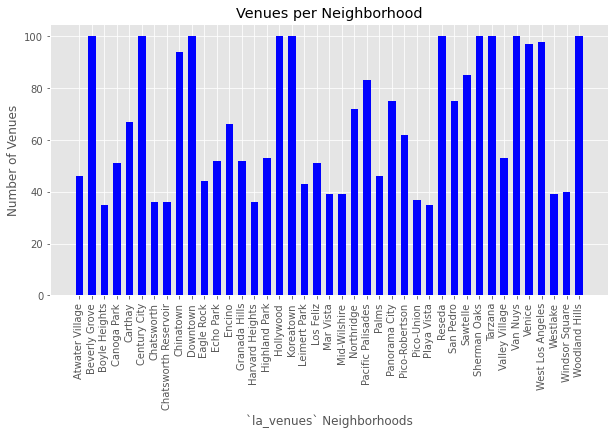

In [15]:
plt.style.use('ggplot')

x = counts_df['Neighborhood'][counts_df['Counts'] >= 34]
y = counts_df['Counts'][counts_df['Counts'] >= 34]

y_pos = np.arange(len(y))
plt.figure(1, [10, 5])

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='blue', width=0.6)
plt.ylabel("Number of Venues")
plt.xlabel("`la_venues` Neighborhoods")
plt.title("Venues per Neighborhood")
plt.xticks(x_pos, x, rotation=90)

print(f"Chart displays {len(x)} neighborhoods.")
print(end='\n')
plt.show()

As expected many popular neighborhoods host the largest number of venues. 

#### Analysis of `elec_neigh`

Earlier we managed to isolate all the electronics stores into the `elec_neigh` dataframe. Lets take a look at their locations on a map.

In [16]:
address = 'Los Angeles, California'

geolocator = Nominatim(user_agent='my-proj')
location = geolocator.geocode(address)
latitude3 = location.latitude
longitude3 = location.longitude

print(f'The geographical coordinates of LA are {latitude3}, {longitude3}.')

print(f"Mapping {elec_neigh.shape[0]} electronics stores.")

electronics_map = folium.Map(location=[latitude3, longitude3], zoom_start=12)

for lat3, lng3, busin in zip(elec_neigh['Venue Latitude'], elec_neigh['Venue Longitude'], elec_neigh['Venue']):
    label3 = folium.Popup(busin, parse_html=True)
    folium.CircleMarker(
        [lat3, lng3], 
        radius = 3.5,
        popup = label3,
        color = 'red',
        fill = True,
        fill_opacity = 0.7).add_to(electronics_map)
    
electronics_map

The geographical coordinates of LA are 34.0536909, -118.242766.
Mapping 59 electronics stores.


From the map above we see that a good portion of the electronics stores reside near Downtown Los Angeles and stretch toward the Santa Monica area as well as a few scattered businesses South of Northridge.

How about we determine on average how many electronics stores are in each neighborhood.

In [17]:
#Let's start by counting how many venues are in each neighborhood.
counts_elec = elec_neigh['Neighborhood'].value_counts()

# We'll put this into a dataframe.
counts_elec_df = pd.DataFrame(counts_elec)
counts_elec_df.reset_index(inplace=True)
counts_elec_df.rename(columns={'index':'Neighborhood', 'Neighborhood':'Counts'}, inplace=True)
counts_elec_df.sort_values('Neighborhood', inplace=True)
counts_elec_df.reset_index(inplace=True, drop=True)

# As a double-check let's verify the number of neighborhoods in `counts_elec_df` match
# the rows in `elec_neigh`.
if len(counts_elec_df['Neighborhood'].unique()) == len(elec_neigh['Neighborhood'].unique()):
    
    print(f"----{counts_elec_df.shape[0]} Neighborhoods----")
    print('\n')
    print(f"The average number of electronics stores in a {500}m radius around a neighborhood is {round(np.array(counts_elec_df['Counts']).mean())}")
    print(f"The maximum number of venues in a neighborhood is {round(np.array(counts_elec_df['Counts']).max())}")
    print(f"The minimum number of venues in a neighborhood is {round(np.array(counts_elec_df['Counts']).min())}")
    
else:
    
    print("Please check neighborhood count match")

----33 Neighborhoods----


The average number of electronics stores in a 500m radius around a neighborhood is 2
The maximum number of venues in a neighborhood is 4
The minimum number of venues in a neighborhood is 1


Similarly, lets compare neighborhoods with the number of venues greater than the average.

Chart displays 16 neighborhoods.



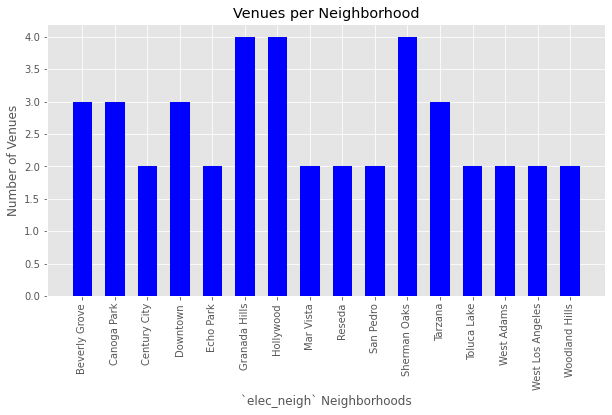

In [38]:
plt.style.use('ggplot')

x2 = counts_elec_df['Neighborhood'][counts_elec_df['Counts'] >= 2]
y2 = counts_elec_df['Counts'][counts_elec_df['Counts'] >= 2]

y_pos2 = np.arange(len(y2))
plt.figure(1, [10, 5])

x_pos2 = [i for i, _ in enumerate(x2)]

plt.bar(x_pos2, y2, color='blue', width=0.6)
plt.ylabel("Number of Venues")
plt.xlabel("`elec_neigh` Neighborhoods")
plt.title("Venues per Neighborhood")
plt.xticks(x_pos2, x2, rotation=90)

print(f"Chart displays {len(x2)} neighborhoods.")
print(end='\n')
plt.show()

#### Analysis of `la_clean`

Lets go ahead and map out venues that are not electronics stores to get a better idea of potential locations to recommend.

In [19]:
address = 'Los Angeles, California'

geolocator = Nominatim(user_agent='my-proj')
location4 = geolocator.geocode(address)
latitude4 = location.latitude
longitude4 = location.longitude

print(f'The geographical coordinates of LA are {latitude4}, {longitude4}.')

print(f"Mapping {la_clean.shape[0]} venues.")

neigh_map = folium.Map(location=[latitude4, longitude4], zoom_start=12)

for lat4, lng4, busin in zip(la_clean['Venue Latitude'], la_clean['Venue Longitude'], la_clean['Venue']):
    label4 = folium.Popup(busin, parse_html=True)
    folium.CircleMarker(
        [lat4, lng4], 
        radius = 3.5,
        popup = label4,
        color = 'purple',
        fill = True,
        fill_opacity = 0.7).add_to(neigh_map)
    
neigh_map

The geographical coordinates of LA are 34.0536909, -118.242766.
Mapping 1477 venues.


Let's find out two things from `la_clean`

* The number of unique categories

* The average number of venues within a neighborhood.

In [20]:
print(f"There are {len(la_clean['Venue Category'].unique())} unique categories.")

There are 110 unique categories.


In [21]:
#Let's start by counting how many venues are in each neighborhood.
counts_clean = la_clean['Neighborhood'].value_counts()

# We'll put this in a dataframe
counts_clean_df = pd.DataFrame(counts_clean)
counts_clean_df.reset_index(inplace=True)
counts_clean_df.rename(columns={'index':'Neighborhood', 'Neighborhood':'Counts'}, inplace=True)
counts_clean_df.sort_values('Neighborhood', inplace=True)
counts_clean_df.reset_index(inplace=True, drop=True)

# As a double-check let's verify the number of neighborhoods in `counts_clean_df` match
# the rows in `la_clean`.
if len(counts_clean_df['Neighborhood'].unique()) == len(la_clean['Neighborhood'].unique()):
    
    print(f"----{counts_clean_df.shape[0]} Neighborhoods----")
    print('\n')
    print(f"The average number of venues in a {500}m radius around a neighborhood is {round(np.array(counts_clean_df['Counts']).mean())}")
    print(f"The maximum number of venues in a neighborhood is {round(np.array(counts_clean_df['Counts']).max())}")
    print(f"The minimum number of venues in a neighborhood is {round(np.array(counts_clean_df['Counts']).min())}") 

else:
    
    print("Please check neighborhood count match")

----72 Neighborhoods----


The average number of venues in a 500m radius around a neighborhood is 21
The maximum number of venues in a neighborhood is 97
The minimum number of venues in a neighborhood is 1


Chart displays 26 neighborhoods.



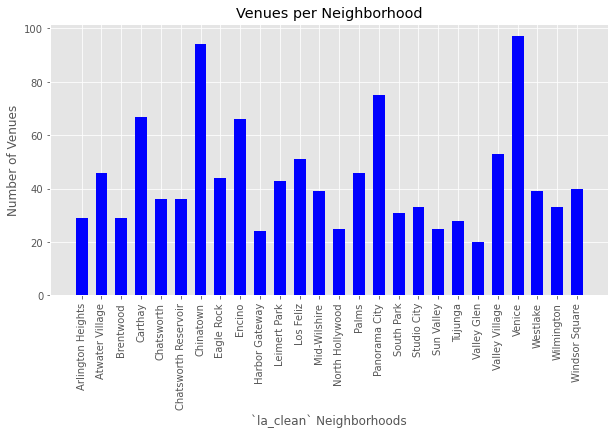

In [39]:
plt.style.use('ggplot')

x3 = counts_clean_df['Neighborhood'][counts_clean_df['Counts'] >= 20]
y3 = counts_clean_df['Counts'][counts_clean_df['Counts'] >= 20]

y_pos3 = np.arange(len(y3))
plt.figure(1, [10, 5])

x_pos3 = [i for i, _ in enumerate(x3)]

plt.bar(x_pos3, y3, color='blue', width=0.6)
plt.ylabel("Number of Venues")
plt.xlabel("`la_clean` Neighborhoods")
plt.title("Venues per Neighborhood")
plt.xticks(x_pos3, x3, rotation=90)

print(f"Chart displays {len(x3)} neighborhoods.")
print(end='\n')
plt.show()

### Analyzing each neighborhood

In [23]:
# one hot encoding
la_clean_onehot = pd.get_dummies(la_clean[['Venue Category']], prefix="", prefix_sep="")

# Let's enclude the neighborhood name column
la_clean_onehot['Neighborhood'] = la_clean['Neighborhood']

fix_columns = [la_clean_onehot.columns[-1]] + list(la_clean_onehot.columns[:-1])
la_clean_onehot = la_clean_onehot[fix_columns]

print(f"The dimensions of `la_clean_onehot` dataframe is {la_clean_onehot.shape[0]} rows and {la_clean_onehot.shape[1]} columns.")
la_clean_onehot.head(15)

The dimensions of `la_clean_onehot` dataframe is 1477 rows and 111 columns.


Neighborhood  ATM  Accessories Store  Antique Shop  \
0            Hancock Park    0                  0             0   
1            Hancock Park    0                  0             0   
2            Hancock Park    0                  0             0   
3    Hollywood Hills West    0                  0             0   
4    Hollywood Hills West    0                  0             0   
5    Hollywood Hills West    0                  0             0   
6         Hollywood Hills    0                  0             0   
7         Hollywood Hills    0                  0             0   
108             Larchmont    0                  0             0   
109             Larchmont    0                  0             0   
110             Larchmont    0                  0             0   
111             Larchmont    0                  0             0   
112             Larchmont    0                  0             0   
113             Larchmont    0                  0             0   
150             Los Feliz    0                  0             0   

     Arts & Crafts Store  Astrologer  Auto Garage  Auto Workshop  Baby Store  \
0                      0           0            0              0           0   
1                      0           0            0              0           0   
2                      0           0            0              0           0   
3                      0           0            0              0           0   
4                      0           0            0              0           0   
5                      0           0            0              0           0   
6                      0           0            0              0           0   
7                      0           0            0              0           0   
108                    0           0            0              0           0   
109                    0           0            0              0           0   
110                    0           0            0              0           0   
111                    0           0            0              0           0   
112                    0           0            0              0           0   
113                    0           0            0              0           0   
150                    0           0            0              0           0   

     Big Box Store  Board Shop  Bookstore  Boutique  Bridal Shop  \
0                0           0          0         0            0   
1                0           0          0         0            0   
2                0           0          0         0            0   
3                0           0          0         0            0   
4                0           0          0         0            0   
5                0           0          0         0            0   
6                0           0          0         0            0   
7                0           0          0         0            0   
108              0           0          0         0            0   
109              0           0          0         0            0   
110              0           0          0         0            0   
111              0           0          0         0            0   
112              0           0          0         0            0   
113              0           0          0         0            0   
150              0           0          0         0            0   

     Business Service  Camera Store  Candy Store  Carpet Store  \
0                   0             0            0             0   
1                   1             0            0             0   
2                   0             0            0             0   
3                   0             0            0             0   
4                   0             0            0             0   
5                   0             0            0             0   
6                   0             0            0             0   
7                   0             0       

Now is a good time to measure the mean of the frequency of occurence of each category. 

In [24]:
la_clean_grouped = la_clean_onehot.groupby('Neighborhood').mean().reset_index()

print(f"{la_clean_grouped.shape[0]} neighborhoods and {la_clean_grouped.shape[1]} features.")
la_clean_grouped.head(30)

72 neighborhoods and 111 features.


Neighborhood       ATM  Accessories Store  Antique Shop  \
0          Adams-Normandie  0.000000           0.000000      0.000000   
1                   Arleta  0.000000           0.000000      0.000000   
2        Arlington Heights  0.000000           0.000000      0.000000   
3          Atwater Village  0.000000           0.000000      0.000000   
4   Baldwin Hills/Crenshaw  0.000000           0.000000      0.000000   
5            Beverly Crest  0.000000           0.000000      0.000000   
6              Beverlywood  0.000000           0.000000      0.000000   
7                Brentwood  0.000000           0.000000      0.000000   
8      Broadway-Manchester  0.000000           0.000000      0.000000   
9                  Carthay  0.000000           0.000000      0.000000   
10         Central-Alameda  0.000000           0.000000      0.000000   
11              Chatsworth  0.027778           0.000000      0.000000   
12    Chatsworth Reservoir  0.027778           0.000000      0.000000   
13     Chesterfield Square  0.000000           0.000000      0.000000   
14           Cheviot Hills  0.000000           0.000000      0.000000   
15               Chinatown  0.000000           0.010638      0.010638   
16            Cypress Park  0.000000           0.000000      0.000000   
17              Eagle Rock  0.045455           0.000000      0.000000   
18               El Sereno  0.000000           0.000000      0.000000   
19            Elysian Park  0.000000           0.000000      0.000000   
20          Elysian Valley  0.000000           0.000000      0.000000   
21                  Encino  0.015152           0.000000      0.000000   
22         Exposition Park  0.000000           0.000000      0.000000   
23           Glassell Park  0.000000           0.062500      0.000000   
24           Gramercy Park  0.000000           0.000000      0.000000   
25            Hancock Park  0.000000           0.000000      0.000000   
26          Harbor Gateway  0.000000           0.000000      0.000000   
27            Harvard Park  0.000000           0.000000      0.000000   
28  Historic South-Central  0.083333           0.000000      0.000000   
29         Hollywood Hills  0.000000           0.000000      0.000000   

    Arts & Crafts Store  Astrologer  Auto Garage  Auto Workshop  Baby Store  \
0              0.000000    0.000000     0.000000       0.000000         0.0   
1              0.000000    0.000000     0.000000       0.000000         0.0   
2              0.000000    0.000000     0.000000       0.000000         0.0   
3              0.065217    0.000000     0.000000       0.000000         0.0   
4              0.000000    0.000000     0.000000       0.000000         0.0   
5              0.000000    0.000000     0.000000       0.000000         0.0   
6              0.000000    0.000000     0.000000       0.000000         0.0   
7              0.000000    0.000000     0.000000       0.000000         0.0   
8              0.000000    0.000000     0.000000       0.000000         0.0   
9              0.000000    0.000000     0.014925       0.000000         0.0   
10             0.000000    0.000000     0.000000       0.000000         0.0   
11             0.000000    0.000000     0.027778       0.000000         0.0   
12             0.000000    0.000000     0.027778       0.000000         0.0   
13             0.000000    0.000000     0.000000       0.000000         0.0   
14             0.000000    0.000000     0.000000       0.000000         0.0   
15             0.031915    0.010638     0.000000       0.021277         0.0   
16             0.000000    0.000000     0.000000       0.000000         0.0   
17             0.000000    0.000000     0.000000       0.022727         0.0   
18             0.000000    0.000000     0.000000       0.000000         0.0   
19             0.000000    0.000000     0.000000       0.000000         0.0   
20             0.000000    0.000000     0.000000       0.000000         0.0   
21          

We'll use the above results to create a dataframe that has the top 10 common venues in each neighborhood.

In [25]:
def return_common_venues(row, top_venues):
    row_category = row.iloc[1:]
    row_category_sorted = row_category.sort_values(ascending=False)
    
    return row_category_sorted.index.values[0:top_venues]

In [26]:
top_venues = 10 

indic = ['st', 'nd', 'rd']

#
columns = ['Neighborhood']
for ind in np.arange(top_venues):
    try:
        columns.append(f"{ind + 1}{indic[ind]} Most Common Venue")
    except:
        columns.append(f"{ind +1}th Most Common Venue")

#
most_common_clean = pd.DataFrame(columns=columns)
most_common_clean['Neighborhood'] = la_clean_grouped['Neighborhood']

for ind in np.arange(la_clean_grouped.shape[0]):
    most_common_clean.iloc[ind, 1:] = return_common_venues(la_clean_grouped.iloc[ind,:], top_venues)
    
most_common_clean.head(10)

Neighborhood       1st Most Common Venue  \
0         Adams-Normandie      Furniture / Home Store   
1                  Arleta  Construction & Landscaping   
2       Arlington Heights  Construction & Landscaping   
3         Atwater Village            Business Service   
4  Baldwin Hills/Crenshaw           Other Repair Shop   
5           Beverly Crest           Convenience Store   
6             Beverlywood            Business Service   
7               Brentwood            Insurance Office   
8     Broadway-Manchester                Home Service   
9                 Carthay                      Lawyer   

        2nd Most Common Venue   3rd Most Common Venue  \
0                   Locksmith       Convenience Store   
1                Home Service           Women's Store   
2                Home Service  Furniture / Home Store   
3                Home Service     Arts & Crafts Store   
4               Women's Store  Furniture / Home Store   
5               Women's Store             Dry Cleaner   
6                 Dry Cleaner           Event Service   
7            Business Service           Jewelry Store   
8  Construction & Landscaping       Mobile Phone Shop   
9            Business Service            Home Service   

        4th Most Common Venue    5th Most Common Venue  \
0  Construction & Landscaping         Recording Studio   
1      Furniture / Home Store            Event Service   
2                 IT Services  Health & Beauty Service   
3  Construction & Landscaping   Thrift / Vintage Store   
4               Event Service              Fabric Shop   
5               Event Service              Fabric Shop   
6                 Fabric Shop           Farmers Market   
7                Home Service   Furniture / Home Store   
8        Marijuana Dispensary            Women's Store   
9                    Pharmacy   Furniture / Home Store   

           6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0              Other Repair Shop             Bookstore         Grocery Store   
1                    Fabric Shop        Farmers Market           Film Studio   
2                   Liquor Store     Other Repair Shop      Business Service   
3                 Clothing Store          Liquor Store   Sporting Goods Shop   
4                 Farmers Market           Film Studio           Fish Market   
5                 Farmers Market           Film Studio           Fish Market   
6                    Film Studio           Fish Market           Flea Market   
7     Construction & Landscaping          Liquor Store  Marijuana Dispensary   
8                    Fabric Shop        Farmers Market           Film Studio   
9  Paper / Office Supplies Store     Mobile Phone Shop        Clothing Store   

  9th Most Common Venue 10th Most Common Venue  
0         Women's Store           Home Service  
1           Fish Market            Flea Market  
2         Grocery Store              Gift Shop  
3        Massage Studio               Boutique  
4           Flea Market            Flower Shop  
5           Flea Market            Flower Shop  
6           Flower Shop      Food & Drink Shop  
7     Food & Drink Shop            Music Store  
8           Fish Market            Flea Market  
9          Camera Store          Smoothie Shop

### Clustering Neighborhoods

Lets run k-means algorithm to cluster the neighborhoods

In [27]:
from sklearn.cluster import KMeans

# cluster locations into five clusters
num_clusters = 6

# kmeans will not accept labels
la_clean_grp_cluster = la_clean_grouped.drop('Neighborhood', axis=1)

# run kmeans 
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(la_clean_grp_cluster)

# print out the cluster labels
kmeans.labels_[0:15]

array([2, 0, 2, 2, 4, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2])

In [28]:
most_common_clean.insert(0, 'Cluster Labels', kmeans.labels_)


la_merged = df_la.join(most_common_clean.set_index('Neighborhood'), on='Neighborhood')
la_merged.dropna(axis=0, inplace=True)

print(f"Dimension check {la_merged.shape}")
la_merged.head(10)

Dimension check (72, 15)


Neighborhood        Region   Latitude   Longitude  Cluster Labels  \
0           Hancock Park  Central L.A.  34.067780 -118.332635             2.0   
1   Hollywood Hills West  Central L.A.  34.110485 -118.373388             2.0   
2        Hollywood Hills  Central L.A.  34.131179 -118.335547             0.0   
4              Larchmont  Central L.A.  34.079837 -118.317870             2.0   
7              Los Feliz  Central L.A.  34.108214 -118.290032             2.0   
8               Mid-City  Central L.A.  34.041527 -118.360370             2.0   
9           Mid-Wilshire  Central L.A.  34.056862 -118.345803             2.0   
11        Elysian Valley  Central L.A.  34.095913 -118.242033             2.0   
12          Elysian Park  Central L.A.  34.077434 -118.238620             2.0   
15             Chinatown  Central L.A.  34.063840 -118.235868             2.0   

     1st Most Common Venue       2nd Most Common Venue  \
0         Business Service                      Lawyer   
1       Photography Studio                 IT Services   
2                Wine Shop  Construction & Landscaping   
4                   Lawyer                Home Service   
7             Home Service                   Pet Store   
8             Home Service      Furniture / Home Store   
9   Furniture / Home Store                Home Service   
11            Home Service  Construction & Landscaping   
12      Photography Studio       Entertainment Service   
15           Jewelry Store                    Pharmacy   

     3rd Most Common Venue       4th Most Common Venue  5th Most Common Venue  \
0           Massage Studio                   Gift Shop            Fabric Shop   
1            Grocery Store     Fruit & Vegetable Store  Entertainment Service   
2    Entertainment Service               Event Service            Fabric Shop   
4              IT Services  Construction & Landscaping          Women's Store   
7                 Boutique               Jewelry Store              Bookstore   
8         Business Service              Lighting Store      Health Food Store   
9   Thrift / Vintage Store                   Pet Store             Smoke Shop   
11          Rental Service               Big Box Store          Women's Store   
12            Food Service         Sporting Goods Shop      Mobile Phone Shop   
15               Gift Shop                    Boutique          Grocery Store   

      6th Most Common Venue    7th Most Common Venue 8th Most Common Venue  \
0            Farmers Market              Film Studio           Fish Market   
1             Event Service              Fabric Shop        Farmers Market   
2            Farmers Market              Film Studio           Fish Market   
4   Fruit & Vegetable Store            Event Service           Fabric Shop   
7              Liquor Store           Cosmetics Shop        Shipping Store   
8                Print Shop             Liquor Store           Flower Shop   
9            Clothing Store             Food Service     Convenience Store   
11  Fruit & Vegetable Store            Event Service           Fabric Shop   
12            Women's Store  Fruit & Vegetable Store         Event Service   
15             Home Service           Clothing Store        Cosmetics Shop   

         9th Most Common Venue 10th Most Common Venue  
0                  Flea Market            Flower Shop  
1                  Film Studio            Fish Market  
2                  Flea Market            Flower Shop  
4               Farmers Market            Film Studio  
7                    Locksmith                 Lawyer  
8       Thrift / Vintage Store      Convenience Store  
9   Construction & Landscaping               Pharmacy  
11              Farmers Market            Film Studio  
12                 Fabric Shop         Farmers Market  
15                   Bookstore          Shopping Mall

Let's visualize our results 

In [29]:
# Matplotlib and colors
import matplotlib.cm as cm
import matplotlib.colors as colors

In [30]:
# Map
cluster_map = folium.Map(location=[latitude4, longitude4], zoom_start=12)

x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat5, lng5, neigh, cluster in zip(la_merged['Latitude'], la_merged['Longitude'], la_merged['Neighborhood'], la_merged['Cluster Labels']):
    label5 = folium.Popup(f"{str(neigh)} Cluster {str(cluster)}")
    folium.CircleMarker(
        [lat5, lng5],
        radius=5, 
        popup=label5,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.5).add_to(cluster_map)
    
cluster_map

Let's take a look at the type of clusters we've obtained. 

In [31]:
cluster_0 = la_merged.loc[la_merged['Cluster Labels'] == 0, la_merged.columns[[0] + list(range(5, la_merged.shape[1]))]]

print(f"There are {len(cluster_0)} neighborhoods in cluster_0")
cluster_0

There are 4 neighborhoods in cluster_0


Neighborhood       1st Most Common Venue  \
2       Hollywood Hills                   Wine Shop   
38         Cypress Park  Construction & Landscaping   
55               Arleta  Construction & Landscaping   
83  Broadway-Manchester                Home Service   

         2nd Most Common Venue  3rd Most Common Venue   4th Most Common Venue  \
2   Construction & Landscaping  Entertainment Service           Event Service   
38               Women's Store            Dry Cleaner           Event Service   
55                Home Service          Women's Store  Furniture / Home Store   
83  Construction & Landscaping      Mobile Phone Shop    Marijuana Dispensary   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
2            Fabric Shop        Farmers Market           Film Studio   
38           Fabric Shop        Farmers Market           Film Studio   
55         Event Service           Fabric Shop        Farmers Market   
83         Women's Store           Fabric Shop        Farmers Market   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
2            Fish Market           Flea Market            Flower Shop  
38           Fish Market           Flea Market            Flower Shop  
55           Film Studio           Fish Market            Flea Market  
83           Film Studio           Fish Market            Flea Market

In [32]:
cluster_1 = la_merged.loc[la_merged['Cluster Labels'] == 1, la_merged.columns[[0] + list(range(5, la_merged.shape[1]))]]

print(f"There are {len(cluster_1)} neighborhoods in cluster_1")
cluster_1

There are 5 neighborhoods in cluster_1


Neighborhood 1st Most Common Venue    2nd Most Common Venue  \
72   Vermont Knolls                   ATM             Home Service   
89     Harvard Park             Gift Shop             Home Service   
95          Tujunga          Home Service              Flower Shop   
96          Sunland          Home Service            Women's Store   
110     Rancho Park          Home Service  Health & Beauty Service   

    3rd Most Common Venue       4th Most Common Venue 5th Most Common Venue  \
72          Grocery Store      Furniture / Home Store         Event Service   
89          Garden Center               Event Service           Fabric Shop   
95          Event Service  Construction & Landscaping  Marijuana Dispensary   
96          Garden Center               Event Service           Fabric Shop   
110         Women's Store      Furniture / Home Store         Event Service   

             6th Most Common Venue 7th Most Common Venue  \
72                     Fabric Shop        Farmers Market   
89                  Farmers Market           Film Studio   
95   Paper / Office Supplies Store            Smoke Shop   
96                  Farmers Market           Film Studio   
110                    Fabric Shop        Farmers Market   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
72            Film Studio           Fish Market            Flea Market  
89            Fish Market           Flea Market            Flower Shop  
95       Business Service        Clothing Store      Convenience Store  
96            Fish Market           Flea Market            Flower Shop  
110           Film Studio           Fish Market            Flea Market

In [33]:
cluster_2 = la_merged.loc[la_merged['Cluster Labels'] == 2, la_merged.columns[[0] + list(range(5, la_merged.shape[1]))]]

print(f"There are {len(cluster_2)} neighborhoods in cluster_2")
cluster_2

There are 57 neighborhoods in cluster_2


Neighborhood       1st Most Common Venue  \
0              Hancock Park            Business Service   
1      Hollywood Hills West          Photography Studio   
4                 Larchmont                      Lawyer   
7                 Los Feliz                Home Service   
8                  Mid-City                Home Service   
9              Mid-Wilshire      Furniture / Home Store   
11           Elysian Valley                Home Service   
12             Elysian Park          Photography Studio   
15                Chinatown               Jewelry Store   
18              Silver Lake           Convenience Store   
20                 Westlake              Clothing Store   
22                  Carthay                      Lawyer   
23           Windsor Square                    Boutique   
24        Arlington Heights  Construction & Landscaping   
25          Lincoln Heights           Mobile Phone Shop   
26                El Sereno                Home Service   
28           Harbor Gateway                Home Service   
31               Wilmington           Mobile Phone Shop   
33          Atwater Village            Business Service   
34            Glassell Park                Home Service   
37               Eagle Rock                Home Service   
40             Porter Ranch            Business Service   
41          North Hollywood                Home Service   
44          Sepulveda Basin            Department Store   
47              Lake Balboa           Mobile Phone Shop   
48            Panorama City            Business Service   
50              Studio City              Cosmetics Shop   
51                 Winnetka                Home Service   
54                   Sylmar            Business Service   
58               Chatsworth                Home Service   
59     Chatsworth Reservoir                Home Service   
60               Sun Valley      Furniture / Home Store   
61                   Encino                Home Service   
64              Valley Glen                Home Service   
69           Valley Village              Cosmetics Shop   
73               South Park                Home Service   
74           Vermont Square            Business Service   
75          University Park              Shipping Store   
76            Vermont Vista           Mobile Phone Shop   
77                    Watts           Mobile Phone Shop   
79          Vermont-Slauson           Mobile Phone Shop   
80          Adams-Normandie      Furniture / Home Store   
81          Exposition Park                   Gift Shop   
84          Central-Alameda            Business Service   
85      Chesterfield Square  Construction & Landscaping   
87            Gramercy Park                    Pharmacy   
90   Historic South-Central               Women's Store   
91             Leimert Park                Home Service   
92           Jefferson Park                Home Service   
93        Manchester Square                Perfume Shop   
94                Hyde Park                Home Service   
99                 Westwood                      Lawyer   
101           Beverly Crest           Convenience Store   
103               Brentwood            Insurance Office   
105                   Palms                Home Service   
107           Cheviot Hills                      Lawyer   
109                  Venice                    Boutique   

          2nd Most Common Venue          3rd Most Common Venue  \
0                        Lawyer                 Massage Studio   
1                   IT Services                  Grocery Store   
4                  Home Service                    IT Services   
7                     Pet Store                       Boutique   
8        Furniture / Home Store               Business Service   
9                  Home Service         Thrift / Vintage Store   
11   Construction & Landscaping                 Rental Service   
12        Entertainment Service                   Food Service  

In [34]:
cluster_3 = la_merged.loc[la_merged['Cluster Labels'] == 3, la_merged.columns[[0] + list(range(5, la_merged.shape[1]))]]

print(f"There are {len(cluster_3)} neighborhoods in cluster_3")
cluster_3

There are 3 neighborhoods in cluster_3


Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
42   North Hills      Business Service           Dry Cleaner   
56    West Hills      Business Service             Locksmith   
102  Beverlywood      Business Service           Dry Cleaner   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
42          Event Service           Fabric Shop        Farmers Market   
56          Garden Center         Event Service           Fabric Shop   
102         Event Service           Fabric Shop        Farmers Market   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
42            Film Studio           Fish Market           Flea Market   
56         Farmers Market           Film Studio           Fish Market   
102           Film Studio           Fish Market           Flea Market   

    9th Most Common Venue 10th Most Common Venue  
42            Flower Shop      Food & Drink Shop  
56            Flea Market            Flower Shop  
102           Flower Shop      Food & Drink Shop

In [35]:
cluster_4 = la_merged.loc[la_merged['Cluster Labels'] == 4, la_merged.columns[[0] + list(range(5, la_merged.shape[1]))]]

print(f"There are {len(cluster_4)} neighborhoods in cluster_4")
cluster_4

There are 2 neighborhoods in cluster_4


Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
49            Shadow Hills     Other Repair Shop         Women's Store   
82  Baldwin Hills/Crenshaw     Other Repair Shop         Women's Store   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
49  Furniture / Home Store         Event Service           Fabric Shop   
82  Furniture / Home Store         Event Service           Fabric Shop   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
49        Farmers Market           Film Studio           Fish Market   
82        Farmers Market           Film Studio           Fish Market   

   9th Most Common Venue 10th Most Common Venue  
49           Flea Market            Flower Shop  
82           Flea Market            Flower Shop

In [36]:
cluster_5 = la_merged.loc[la_merged['Cluster Labels'] == 5, la_merged.columns[[0] + list(range(5, la_merged.shape[1]))]]

print(f"There are {len(cluster_5)} neighborhoods in cluster_5")
cluster_5

There are 1 neighborhoods in cluster_5


Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
39  Lake View Terrace           Record Shop         Women's Store   

   3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
39        Discount Store  Entertainment Service         Event Service   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
39           Fabric Shop        Farmers Market           Film Studio   

   9th Most Common Venue 10th Most Common Venue  
39           Fish Market            Flea Market

In [37]:
cluster_6 = la_merged.loc[la_merged['Cluster Labels'] == 6, la_merged.columns[[0] + list(range(5, la_merged.shape[1]))]]

print(f"There are {len(cluster_6)} neighborhoods in cluster_6")
cluster_6

There are 0 neighborhoods in cluster_6


Empty DataFrame
Columns: [Neighborhood, 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue, 6th Most Common Venue, 7th Most Common Venue, 8th Most Common Venue, 9th Most Common Venue, 10th Most Common Venue]
Index: []

This concludes our analysis. We created 6 clusters representing neighborhoods with similar venues and containing no electronics stores. In our analysis, we searched for venues using a 500m radius around each neighborhood but it is important to keep in mind venues outside of this range may exist including electronics stoores not recognized by Fouresquare. We note that ~79% of the neighborhoods in `la_clean` belong to `cluster_2` for the reason that they share similar venues such as clothing stores, furniture/home stores, department stores, and convenience stores just to name a few.

## Results & Discussion <a name="res"></a>

Our analysis shows that roughly 79% of neighborhoods fall under the `cluster_2` group making it the only cluster with the largest number of neighborhood membership. Locations in this cluster share similar venues such as 'Business Services', 'Photography Studios', 'Convenience Stores', and 'Furniture/Home Store' are examples of such venues. We'd also like to focus our attention to locations strictly in `cluster_2` since many venues compliment a computer electronics store compared to venues in all other clusters. From these, we will present three optimal locations for a computer electronics store business and at the same time provide reasons why we chose each of them.  

The first location is Venice. Venice is one of the most popular beaches in Southern California and hosts roughly 30,000 people daily according to [laparks.org](https://www.laparks.org/venicehttps://www.laparks.org/venice). This neighborhood is a top choice on our lists not only for the ~10 million visitors it receives per year but rather for the 97 Shop & Service venues that compliment our stakeholder's business. Venues in several categories such as home services, men's/women's stores, and bookstores all offer services that many computer enthusiasts, online gamers, and the general public benefit from. This means that not only do our stakeholders offer product to local customers but to individuals touring the neighborhood.

The second location we recommend is Chinatown. Well known as a commercial center for its Asian businesses, Chinatown sits roughly 1.6 miles North of Downtown Los Angeles and is home to 94 Shop & Service venues. One of the main benefits of this neighborhood is the Dynasty Shopping Mall and the Chinatown Saigon Shopping Mall both of which are situated around a large population of retail stores. This location offers a great opportunity to attract additional customers outside of our stakeholder's targeted audience.

The third and final location we recommend is Panorama City. This locations hosts 75 Shop & Service venues including a shopping mall and a shopping center. Panorama City having been one of the largest major retail store outlets in the San Fernando Valley region, it also offers one of the youngest age range populations. The median age in Panorama City is approximately 34 years of age ([censusreporter.org](https://censusreporter.org/profiles/79500US0603723-los-angeles-county-north-la-city-north-centralmission-hills-panorama-city-puma-ca/)). According to a [statista.com](https://www.statista.com/statistics/189582/age-of-us-video-game-players-since-2010/#:~:text=During%20a%202020%20survey%2C%2038,are%2065%20years%20and%20older.) 2020 survey, about 38% of online gamers fall into the 18-34 age range. Thus this Panorama City is an optimal location that offers a young audience to cater a computer electronics store along with its reputation as a major retail store outlet. 

Each location was chosen carefully by taking into consideration the attention it would provide our stakeholder's business mainly through its popularity and the number of retail stores in the area. When deciding which location would be recommended first came down to the its ability to attract an audience outside of our targeted customers. As another requirement we decided to take into account the number of venues in the area and whether a computer electronics store would thrive in such an area. Ultimately, we decided Venice was our top choice followed by Chinatown and Panorama City. While the locations we recommended are our top choices there are of course many other locations in which a computer electronics store may thrive in by taking into account the number of electronics stores previously established in each neighborhood, what specific addresses within a neighborhood are optimal locations, or what specific category of venues most compliments a computer electronics store. These are only a few directions we could consider during future follow ups. 

## Conclusion <a name="con"></a>

In this project we identified three optimal locations for a computer electronics store in the city of Los Angeles, CA. We identified a total of 3535 venues within 105 neighborhoods using the Foursquare API. During this processes we remove 33 neighborhoods that contained electronics stores and used the remaining 72 neighborhoods for our recommendation. We used k-means clustering to group similar locations based on common venues. The decision process made use of the candidate location's population of venues, location popularity, and the category of venues offered. From this we recommended to our stakeholders three optimal neighborhoods: Venice, Chinatown, and Panorama City.